In [256]:
from IPython.display import Audio

import time
import librosa
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [463]:
input_filename = "data/Give Me the Night Gui Rivero 7zg0Xngdg88TroKhEURD9r.mp3"
y, sr = librosa.load(input_filename)
print(len(y))
# start_time, end_time = 73, 7300
# y = y[librosa.time_to_samples(start_time, sr=sr):librosa.time_to_samples(end_time, sr=sr)]
# print(len(y))

7427216


In [464]:
# seconds
min_loop_duration = 10
max_loop_duration = 15
hop_duration = 50e-3
slide_step_duration = 10e-3

# https://www.pnas.org/doi/10.1073/pnas.0407034102
# Thus, differential latencies between auditory and visual processing agree well with
# the common finding that auditory signals must lag visual signals by ≈40–50 ms if they
# are to be perceived as temporally aligned.
# 100 ms window correlation window
corr_duration = 200e-3

# calculate the minimum and maximum loop length in samples
min_loop_samples = librosa.time_to_samples(min_loop_duration, sr=sr)
max_loop_samples = librosa.time_to_samples(max_loop_duration, sr=sr)
hop_samples = librosa.time_to_samples(hop_duration, sr=sr)
slide_samples = librosa.time_to_samples(slide_step_duration, sr=sr)
corr_samples = librosa.time_to_samples(corr_duration, sr=sr)

# choose the end of the loop and search for the start
end_idxs = np.arange(min_loop_samples, len(y)-corr_samples, hop_samples)
jumps = len(end_idxs)
slides = int((max_loop_duration-min_loop_duration)/slide_step_duration) + 1
print(f"Searching through {jumps} loop end times ({hop_duration} second jumps).")
print(f"Look for loops between {min_loop_duration} to {max_loop_duration} seconds")
print(f"by sliding a {corr_duration*1e3} ms window with step of {slide_step_duration*1e3} ms ({slides} steps).")

correlations = np.full((jumps, slides), fill_value=0, dtype=float)

print_n = 50
t0 = time.time()
t1 = time.time()
for jump_idx, end_idx in enumerate(end_idxs):
    # take the next corr_samples. this window represent the start of the loop
    template_samples = y[end_idx:end_idx+corr_samples]
    # jump back to max duration and slide the window to the min duration
    for slide_idx in range(slides):
        start_idx = end_idx-max_loop_samples + slide_idx*slide_samples
        if start_idx<0: continue
        match_samples = y[start_idx:start_idx+corr_samples]
        corr = pearsonr(template_samples, match_samples).correlation
        # https://numpy.org/doc/stable/reference/generated/numpy.correlate.html
        # scipy.signal.correlate
        correlations[jump_idx, slide_idx] = corr if not np.isnan(corr) else 0
    dt = time.time() - t0
    if (jump_idx+1)%print_n==0:
        dt1 = time.time() - t1
        print(f"{jump_idx+1}/{jumps}. {dt:.1f}s. {1e3*dt1/print_n:.1f} ms/jump. {(jumps-jump_idx)*dt1/print_n:.1f} s remaining", end="\r")
        t1 = time.time()
print(f"{jump_idx+1}/{jumps}. {dt:.1f}s. {1e3*dt/(jump_idx+1):.1f} ms/jump. {(jumps-jump_idx)*dt/(jump_idx+1):.1f} s remaining", end="\r")


Searching through 6536 loop end times (0.05 second jumps).
Look for loops between 10 to 15 seconds
by sliding a 200.0 ms window with step of 10.0 ms (501 steps).


586


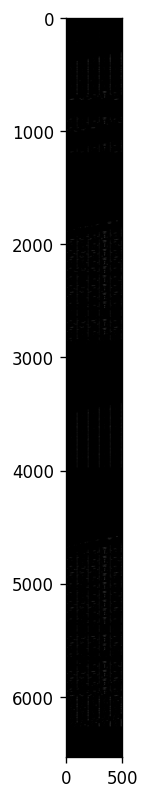

In [465]:
print( np.sum(correlations>0.9*correlations.max()) )
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
im = ax.imshow(correlations>0.5*correlations.max(), cmap="gray")


In [466]:
# max correlation in at each end jump
jump_max_idx = np.argmax(correlations, axis=1)
jump_max_cor = np.amax(correlations, axis=1)
sorted_idx = np.argsort(jump_max_cor)[::-1]
idx_iter = iter(range(jumps))


In [470]:
idx = next(idx_iter)
jump_loc = sorted_idx[idx]
slide_loc = jump_max_idx[jump_loc]
end_sample = min_loop_samples + jump_loc*hop_samples
start_sample = end_sample-max_loop_samples + slide_loc*slide_samples
extract_samples = y[start_sample:end_sample]
print(f"{idx=}. {jump_loc=}. {slide_loc=}.")
print(f"{librosa.samples_to_time(start_sample, sr=sr)} to {librosa.samples_to_time(end_sample, sr=sr)}")

a = Audio(data=extract_samples, rate=sr, autoplay=True)
a.autoplay_attr = lambda: 'autoplay="autoplay" loop="loop"'
a


idx=3. jump_loc=5011. slide_loc=0.
245.43637188208618 to 260.4363718820862
